In [1]:
%matplotlib inline
import numpy as np
import scipy
import pyttsx3
from scipy.io import wavfile
from scipy import fft
from scipy.signal import blackman, find_peaks
from matplotlib import pyplot as plt
from midiutil.MidiFile import MIDIFile

In [2]:
engine = pyttsx3.init()
engine.say("I will speak this text")
engine.runAndWait()
engine.save_to_file('Hello, how are you?', './test.mp3')
_ = !ffmpeg -y -i test.mp3 test.wav

In [3]:
samplerate, data = wavfile.read('./test.wav')

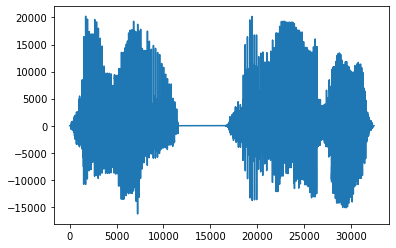

In [4]:
# data = data[250:4000]
plt.plot(data)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


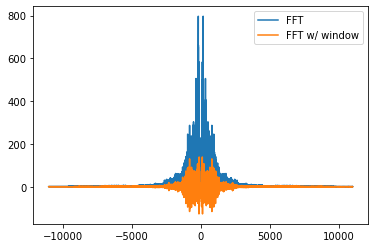

In [5]:
# Every frequency fft
N = data.shape[0]
yf = fft.fft(data)
xf = fft.fftfreq(N, 1 / samplerate)

w = blackman(N)
wyf = fft.fft(data*w)

plt.plot(xf, 2.0/N * np.abs(yf), label='FFT')
plt.plot(xf, 2.0/N * (wyf), label='FFT w/ window')
plt.legend()

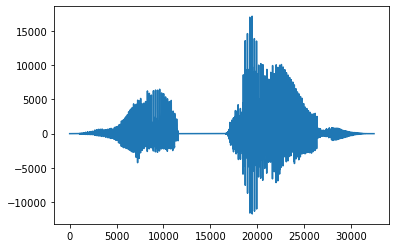

In [6]:
plt.plot(data*w)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


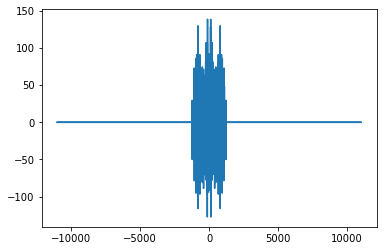

In [7]:
# Top frequency fft
N_FREQS = 1000
idx = np.argpartition(-np.abs(wyf), N_FREQS)[:N_FREQS]

fyf = np.zeros_like(wyf)
fyf[idx] = wyf[idx]
plt.plot(xf, 2.0/N * (fyf))

/opt/homebrew/Caskroom/miniconda/base/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


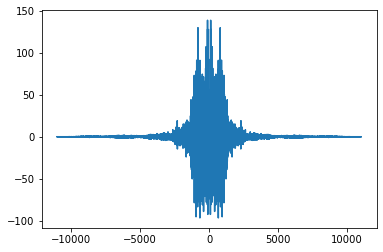

In [8]:
# Find peaks
idx, _ = find_peaks(np.abs(wyf), distance=1)

peaks_yf = np.zeros_like(wyf)
peaks_yf[idx] = wyf[idx]
plt.plot(xf, 2.0/N * (peaks_yf))

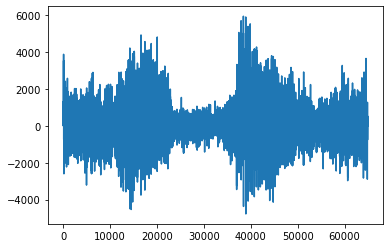

In [9]:
recover_data = fft.irfft(peaks_yf)
plt.plot(recover_data)

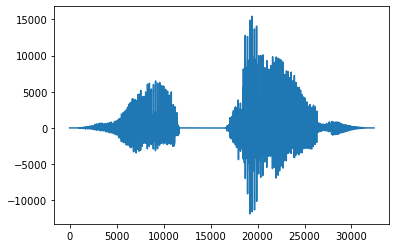

In [10]:
# Now, how Jack The Ripper would said let's go by parts
sections = np.array_split(data*w, N // 500)
recover_data = np.array([])
freqs_chords = []
for section in sections:
    n = section.shape[0]
    yf = fft.rfft(section)
    xf = fft.rfftfreq(n, 1 / samplerate)
#     plt.plot(xf, yf)
#     plt.show()
#     from time import sleep
#     sleep(1)

    # Find peaks method
    #idx, _ = find_peaks(np.abs(yf), distance=10)
    
    # N hightest freqs method
    N_FREQS = 25
    idx = np.argpartition(-np.abs(yf), N_FREQS)[:N_FREQS]

    peaks_yf = np.zeros_like(yf)
    peaks_yf[idx] = yf[idx]
#     plt.plot(xf, 2.0/N * (np.abs(peaks_yf)))
#     plt.show()
    freqs_chords.append((xf[idx], np.abs(yf[idx])))
    recover_data = np.concatenate([recover_data, fft.irfft(peaks_yf)])
plt.plot(recover_data)

In [11]:
wavfile.write('./recover_test.wav', samplerate, recover_data)

In [12]:
def freq2mid(freq):
    return 69 + 12*np.log2(freq / 440)

In [13]:
from mido import Message, MidiFile, MidiTrack
mid = MidiFile()
track = MidiTrack()
mid.tracks.append(track)
track.append(Message('program_change', program=12, time=0))
chords = [[freq2mid(chord).round().astype(np.int16), intensities] for chord, intensities in freqs_chords]

for chord in chords:
    intensities = chord[1]
#     chord[1] = intensities / intensities.max()
    chord[1] = 2.0 / N * intensities
#     plt.bar(chord[0], chord[1])
#     plt.show()
    for note, intensity in zip(*chord):
        if intensity > 5:
            track.append(Message('note_on', note=note, velocity=64, time=0))
    track.append(Message('note_on', note=note, velocity=64, time=1))
    for note, intensity in zip(*chord):
        track.append(Message('note_off', note=note, velocity=64, time=1))
mid.save('new_song.mid')

/var/folders/th/h_b6fb4s5kx77mr9j442kbh80000gn/T/ipykernel_71153/3941799596.py:2: RuntimeWarning: divide by zero encountered in log2
  return 69 + 12*np.log2(freq / 440)
